In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install lingpy
#import lingpy
#from lingpy import ipa2tokens
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #For debugging
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## IELEX

In [3]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

ilexPairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ilexPairs.append((word1, word2, label))

import csv

# Initialize an empty set to store the languages
languages = set()

# Open and read the CSV file with UTF-8 encoding and error handling
with open('data/ielexData.csv', 'r', encoding='utf-8', errors='replace') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        languages.add(row[1])  # Add the language (second column) to the set

# Print the set of languages
print(languages)

df

{'Russian', 'Welsh', 'Lithuanian', 'Breton', 'Catalan', 'Bengali', 'Spanish', 'Icelandic', 'Romanian', 'French', 'Portuguese', 'Nepali', 'Dutch', 'German', 'Swedish', 'Czech', 'Polish', 'Danish', 'Hindi', 'Irish', 'Ukrainian', 'Italian', 'English', 'Greek', 'Bulgarian'}


,meaning,word,cognate_class
0,few,ˈliʝi,few:I
1,few,ˈmaɫku,few:H
2,few,'maɫɔ,few:H
3,few,ˈmawɔ,few:H
4,few,ˈmaɫɔ,few:H
...,...,...,...
4479,head,tɛt,head:D
4480,head,'tɛsta,head:D
4481,head,kap,head:B
4482,head,ˈpɛnː,head:E


## GLED

### Preprocessing

In [4]:
df = pd.read_csv("data/gled.tsv", delimiter="\t")

df.rename(columns={'LANGUAGE_NAME': 'Language'}, inplace=True)

df['Language'] = df['Language'].str.replace('Modern Greek', 'Greek', regex=False)

df = df[df['Language'].isin(languages)]

#df = df[df.apply(lambda row: row['DOCULECT'].lower() in row['Language'].lower(), axis=1)]

#These languages seem to be aight
#df = df[df["DOCULECT"].str.contains("_2")]

#df.dropna(subset=["COGSET"], inplace=True) All of them have a cogset

df

,ID,DOCULECT,Language,GLOTTOCODE,GLOTTOLOG_NAME,FAMILY,CONCEPT,CONCEPTICON_ID,ASJP_FORM,FORM,IPA,ALIGNMENT,COGSET,COGSET_INT
144314,BRETON.1pl-3159,BRETON,Breton,bret1244,Breton,Indo-European,1pl,1212,ni,ni,n i,n i - - - -,indoeuropean.1pl.0001,18691
144315,BULGARIAN_2.1pl-3162,BULGARIAN_2,Bulgarian,bulg1262,Bulgarian,Indo-European,1pl,1212,niE,nia,n i a,n i - - - a,indoeuropean.1pl.0001,18691
144321,FRENCH_2.1pl-3210,FRENCH_2,French,stan1290,French,Indo-European,1pl,1212,nu,nu,n u,n u - - - -,indoeuropean.1pl.0001,18691
144324,ITALIAN_2.1pl-3242,ITALIAN_2,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
144325,ITALIAN_GROSSETO_TUSCAN.1pl-3243,ITALIAN_GROSSETO_TUSCAN,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158460,IRISH_GAELIC.water-259902,IRISH_GAELIC,Irish,iris1253,Irish,Indo-European,water,948,iSky3,iʃkjə,i ʃ k j ə,- i - ʃ k j ə,indoeuropean.water.0950,19640
158464,GREEK.water-259881,GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158465,MODERN_GREEK.water-259969,MODERN_GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158481,HINDI_2.water-259895,HINDI_2,Hindi,hind1269,Hindi,Indo-European,water,948,j3l,dʒəl,dʒ ə l,dʒ ə l,indoeuropean.water.0961,19651


In [5]:
df = df[['CONCEPT', 'FORM', 'COGSET']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

pairs = []

from tqdm.notebook import tqdm
for _, group in tqdm(df.groupby('meaning')):
    #if len(pairs) > 100000:
    #    break

    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        if(word1 == word2):
            continue
        label = int(w1['cognate_class'] == w2['cognate_class'])
        #if label == 1:
        pairs.append((word1, word2, label))

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
pairs += ilexPairs

In [7]:
pairs

[('ni', 'nia', 1),
 ('ni', 'nu', 1),
 ('ni', 'noi', 1),
 ('ni', 'noi', 1),
 ('ni', 'noʃ', 1),
 ('ni', 'noj', 1),
 ('ni', 'həm', 0),
 ('ni', 'ɐmrɐ', 0),
 ('ni', 'ma', 0),
 ('ni', 'mi', 0),
 ('ni', 'midj', 0),
 ('ni', 'mɐ', 0),
 ('ni', 'mes', 0),
 ('ni', 'mi', 0),
 ('ni', 'mə', 0),
 ('ni', 'mə', 0),
 ('ni', 'mi', 0),
 ('ni', 'noltros', 0),
 ('ni', 'nuzɐʎtrəs', 0),
 ('ni', 'nosotros', 0),
 ('ni', 'nosɐltres', 0),
 ('ni', 'vi', 0),
 ('ni', 'və', 0),
 ('ni', 'vai', 0),
 ('ni', 'wi', 0),
 ('ni', 'vir', 0),
 ('ni', 'vi', 0),
 ('ni', 'viθ', 0),
 ('ni', 'ʃinj', 0),
 ('ni', 'ʃiɲ', 0),
 ('ni', 'emis', 0),
 ('ni', 'emis', 0),
 ('ni', 'vɐalə', 0),
 ('nia', 'nu', 1),
 ('nia', 'noi', 1),
 ('nia', 'noi', 1),
 ('nia', 'noʃ', 1),
 ('nia', 'noj', 1),
 ('nia', 'ni', 1),
 ('nia', 'həm', 0),
 ('nia', 'ɐmrɐ', 0),
 ('nia', 'ma', 0),
 ('nia', 'mi', 0),
 ('nia', 'midj', 0),
 ('nia', 'mɐ', 0),
 ('nia', 'mes', 0),
 ('nia', 'mi', 0),
 ('nia', 'mə', 0),
 ('nia', 'mə', 0),
 ('nia', 'mi', 0),
 ('nia', 'noltros', 0),


In [8]:
pairs_df = pd.DataFrame(pairs, columns=['Word1', 'Word2', 'Label'])
pairs_df

,Word1,Word2,Label
0,ni,nia,1
1,ni,nu,1
2,ni,noi,1
3,ni,noi,1
4,ni,noʃ,1
...,...,...,...
75251,voj,xwi,1
75252,voj,ʃivʲ,1
75253,"ˈxwi, ˈhwi",xwi,1
75254,"ˈxwi, ˈhwi",ʃivʲ,1


### Levenshtein distance preprocessing

In [9]:
all_pairs = [row[:2] for row in pairs]
all_labels = [row[2] for row in pairs]
#all_labels = [row[2:] for row in pairs]

all_characters_in_pairs = set()
for pair in all_pairs: #For all words (indiscriminately)
    for word in pair:
        all_characters_in_pairs.update(word)

class SetEmbedding:
    def __init__(self, set_of_things, embedding_dim):
        import torch
        import torch.nn as nn
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(len(set_of_things), embedding_dim, padding_idx=0, _freeze=True)

        self.ids = {thing: torch.tensor([idx]) for idx, thing in enumerate(set_of_things)}

    def __call__(self, character):
        # This is a dummy embedding; replace with your actual embedding function
        return self.embedding(self.ids[character])

class FrozenIPAEmbedding:
	def __init__(self, char_to_idx, weights, embedding_dim=6):
		self.embedding_dim = embedding_dim
		self.char_to_idx = char_to_idx
		self.embeddings = nn.Embedding.from_pretrained(weights, freeze=True, padding_idx=0)
	
	def __call__(self, character):
		idx = self.char_to_idx.get(character, 0)  # Default to 0 (PAD) for unseen chars
		return self.embeddings(torch.tensor([idx], device=device))

class IPAEmbedding:
	def __init__(self, embedding_dim=6):
		self.embedding_dim = embedding_dim
		
		# Load GLED data for training character embeddings
		gled_df = pd.read_csv("data/gled.tsv", delimiter="\t")
		words = gled_df['FORM'].dropna().tolist()
		
		# Create character contexts for word2vec-style training
		contexts = []
		for word in words:
			if not isinstance(word, str):
				continue
			chars = list(word)
			if len(chars) <= 1:
				continue
			# For each character, create context pairs with surrounding characters
			for i in range(len(chars)):
				# Use a window of 2 characters on each side
				context_start = max(0, i-2)
				context_end = min(len(chars), i+3)
				target = chars[i]
				context = chars[context_start:i] + chars[i+1:context_end]
				contexts.append((target, context))
		
		# Create vocabulary of unique characters
		self.char_to_idx = {char: idx+1 for idx, char in enumerate(all_characters_in_pairs)}
		self.char_to_idx['<PAD>'] = 0
		self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
		vocab_size = len(self.char_to_idx)
		
		# Initialize embedding matrices
		import torch.nn as nn
		self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
		
		# Train character embeddings using negative sampling approach
		self._train_embeddings(contexts, epochs=1)
		
	def _train_embeddings(self, contexts, epochs=1, batch_size=128, lr=0.01):
		import random
		import torch.optim as optim
		import torch.nn.functional as F
		
		optimizer = optim.Adam(self.embeddings.parameters(), lr=lr)
		
		from tqdm import tqdm
		for epoch in range(epochs):
			random.shuffle(contexts)
			total_loss = 0
			
			for i in tqdm(range(0, len(contexts), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
				batch = contexts[i:i+batch_size]
				
				# Prepare target and context tensors
				target_chars = [pair[0] for pair in batch]
				context_chars = [pair[1] for pair in batch]
				
				# Convert to indices
				target_indices = torch.tensor([self.char_to_idx.get(char, 0) for char in target_chars], device=device)
				
				# Process each context
				batch_loss = 0
				for idx, (target_idx, context) in enumerate(zip(target_indices, context_chars)):
					context_indices = torch.tensor([self.char_to_idx.get(char, 0) for char in context], device=device)
					if len(context_indices) == 0:
						continue
					
					# Get embeddings
					target_emb = self.embeddings(target_idx)
					context_embs = self.embeddings(context_indices)
					
					# Calculate similarity
					similarity = F.cosine_similarity(target_emb.unsqueeze(0), context_embs, dim=1)
					
					# Use binary cross entropy with positive examples
					pos_loss = -torch.log(torch.sigmoid(similarity)).mean()
					
					# Negative sampling
					neg_indices = torch.randint(1, len(self.char_to_idx), (len(context)*3,), device=device)
					neg_embs = self.embeddings(neg_indices)
					neg_similarity = F.cosine_similarity(target_emb.unsqueeze(0), neg_embs, dim=1)
					neg_loss = -torch.log(1 - torch.sigmoid(neg_similarity)).mean()
					
					# Combined loss
					loss = pos_loss + neg_loss
					batch_loss += loss
				
				if batch_loss > 0:
					optimizer.zero_grad()
					batch_loss.backward()
					optimizer.step()
					total_loss += batch_loss.item()

				# if i > 10000:
				# 	break
			
			if epoch % 2 == 0:
				print(f"Epoch {epoch}, Loss: {total_loss/max(1, len(contexts)//batch_size):.4f}")
		
		print("Character embedding training complete")
	
	def __call__(self, character):
		idx = self.char_to_idx.get(character, 0)  # Default to 0 (PAD) for unseen chars
		return self.embeddings(torch.tensor([idx], device=device))
	
	def frozen(self):
		return FrozenIPAEmbedding(self.char_to_idx, self.embeddings.weight.detach(), embedding_dim=self.embedding_dim)

ipa_embedder = IPAEmbedding(embedding_dim=6)

Epoch 1/1: 100%|██████████| 8645/8645 [51:16<00:00,  2.81it/s]  


Epoch 0, Loss: 113.2641
Character embedding training complete


In [10]:
ipa_embedder = ipa_embedder.frozen()
from LDistanceModel import create_batch_with_masks
import torch
import random
from tqdm.notebook import tqdm
ldistance_operations, ldistance_masks, ldistance_lengths = create_batch_with_masks(all_pairs, ipa_embedder, device)

pairs = (ldistance_operations, ldistance_masks, torch.tensor(all_labels, device=device, dtype=torch.float))

100%|██████████| 75256/75256 [05:57<00:00, 210.55it/s]


In [11]:
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
import numpy as np
from tqdm.notebook import tqdm
import time

def cv_test_model(model_maker, has_history=False):
	cv = StratifiedKFold(n_splits = 40)
	epochs = 500

	# Store results for each fold
	# All of these are [epoch_number, fold, (confusion_matrix, accuracy)]

	timestamps = min(30, epochs)
	
	def is_epoch_return_epoch_number(epoch):
		if epoch == 0:
			return 0

		interval = epochs / timestamps

		if epoch % interval < 1:
			return int(epoch // interval)
		return None
	
	def epoch_number_filter(epoch):
		return is_epoch_return_epoch_number(epoch) != None
	
	history = {
		"train": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		],
		"test": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		]
	}

	for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(pairs[0], pairs[2].cpu()), total=cv.get_n_splits(), desc="CV Progress")):
		train_idx = torch.tensor(train_idx)
		test_idx = torch.tensor(test_idx)

		# Split data
		train_data = list(zip(torch.index_select(pairs[0], 0, train_idx), torch.index_select(pairs[1], 0, train_idx), torch.index_select(pairs[2], 0, train_idx)))
		test_data = list(zip(torch.index_select(pairs[0], 0, test_idx), torch.index_select(pairs[1], 0, test_idx), torch.index_select(pairs[2], 0, test_idx)))
		
		# Create model for this fold
		model = model_maker()
		criterion = nn.BCELoss()
		optimizer = optim.Adam(model.parameters(), lr=0.001)
		
		train_loader = DataLoader(train_data, batch_size=3200, shuffle=True, 
								generator=torch.Generator(device=device.type))
		test_loader = DataLoader(test_data, batch_size=3200, 
								generator=torch.Generator(device=device.type))
		
		
		def test_against_loader(model, loader):
			"""
			Modified test_against_loader that returns predictions, probabilities, and true labels
			"""
			predictions = []
			probabilities = []  # Raw model outputs (probabilities)
			true_labels = []

			with torch.no_grad():
				for word1_batch, word2_batch, label_batch in loader:
					output_batch = model(word1_batch, word2_batch).squeeze()
					predicted_batch = (output_batch > 0.5).int()

					# Store results for the entire batch
					predictions.extend(predicted_batch.tolist())
					probabilities.extend(output_batch.tolist())  # Store raw probabilities
					true_labels.extend(label_batch.int().tolist())

			# Calculate accuracy
			accuracy = sum([pred == true for pred, true in zip(predictions, true_labels)]) / len(true_labels)

			# Additional metrics
			from sklearn.metrics import confusion_matrix
			
			# Calculate confusion matrix
			conf_matrix = confusion_matrix(true_labels, predictions)

			return conf_matrix, accuracy, probabilities, true_labels

		# Train model
		model.train()
		for epoch in tqdm(range(epochs), desc=f"Fold {fold}"):
			total_loss = 0
			for operations, masks, labels in train_loader:	# Plural, because it's batches
				optimizer.zero_grad()
				output = model(operations, masks).squeeze()
				#print(output.get_device(), label.get_device())
				loss = criterion(output, labels)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			#print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

			if has_history:
				epoch_number = is_epoch_return_epoch_number(epoch)
				if epoch_number == None:
					continue
				model.eval()
				history["train"][epoch_number][fold] = test_against_loader(model, train_loader)
				history["test"][epoch_number][fold] = test_against_loader(model, test_loader)

				#Early cutoff if overfitting
				if history["train"][epoch_number][fold][1] >= .99:
					history["train"] = history["train"][0:epoch_number]
					history["test"] = history["test"][0:epoch_number]
					return history, model
				
				model.train()

		if not has_history:
			history["test"][-1][fold] = test_against_loader(model, test_loader)

	return history, model

In [12]:
ipa_embedder.embedding_dim + 2

8

In [13]:
from LDistanceModel import LDistanceModel
#from lstm_stuff import SimplePairNN
def l_distance_model_maker():
    hidden_dim = 32
    num_layers = 4
    num_head = 4

    #return SimplePairNN(vocab_size, embedding_dim, hidden_dim)
    return LDistanceModel(ipa_embedder, hidden_dim, num_layers, num_head)

history, model = cv_test_model(l_distance_model_maker, has_history=True)

CV Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 0:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 1:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 2:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 3:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 4:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 5:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 6:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 7:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 8:   0%|          | 0/500 [00:00<?, ?it/s]

Fold 9:   0%|          | 0/500 [00:00<?, ?it/s]


Cross-Validation Results:
Overall Accuracy: 75.51%
Correct Predictions: 56825/75256


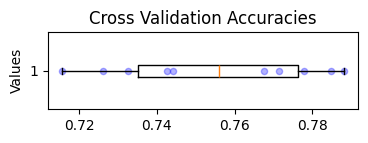

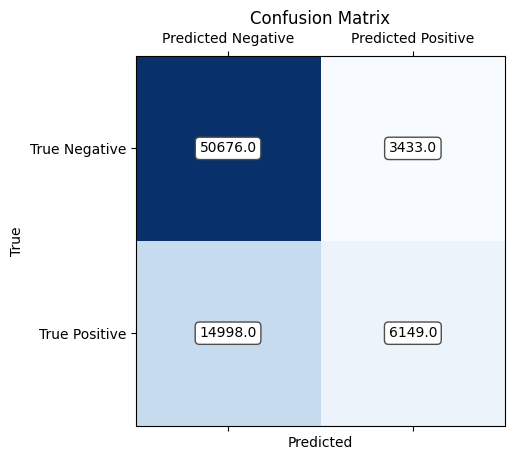

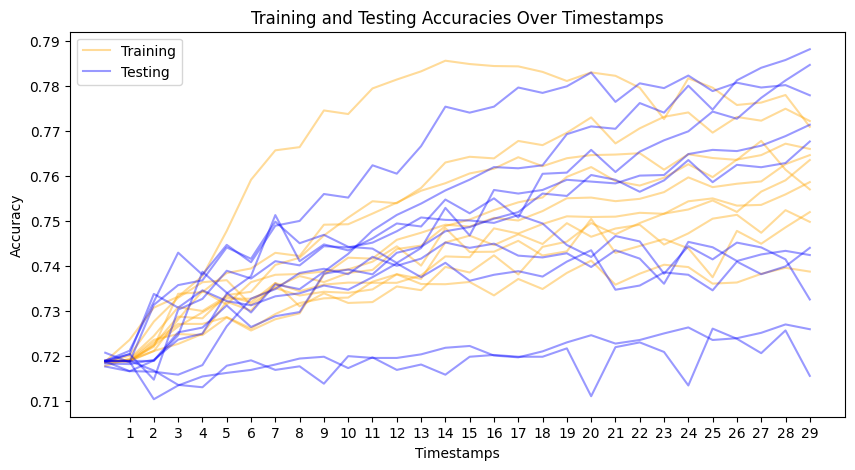

In [14]:
# Calculate overall statistics
last_epoch_test_data = history["test"][-1] #[fold, (pred, labels, accuracies, accuracy)]

all_confusion = np.sum(np.array([fold_data[0] for fold_data in last_epoch_test_data]), axis=0)
all_accuracies = [fold_data[1] for fold_data in last_epoch_test_data]

overall_accuracy = np.mean(all_accuracies)
correct_predictions = all_confusion[1][1] + all_confusion[0][0]
total_predictions = np.sum(all_confusion)

print(f"\nCross-Validation Results:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

fold_accuracies = [fold_data[1] for fold_data in history["test"][-1]]

from visualization_stuff import show_box_plot, show_confusion_matrix, show_train_and_test_accuracy_over_epochs
show_box_plot(fold_accuracies)

show_confusion_matrix(all_confusion)

show_train_and_test_accuracy_over_epochs(history)

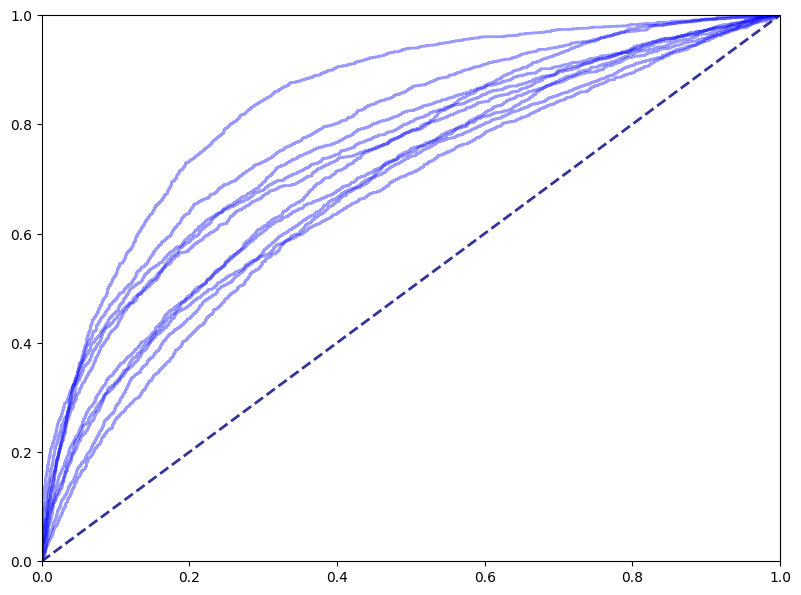

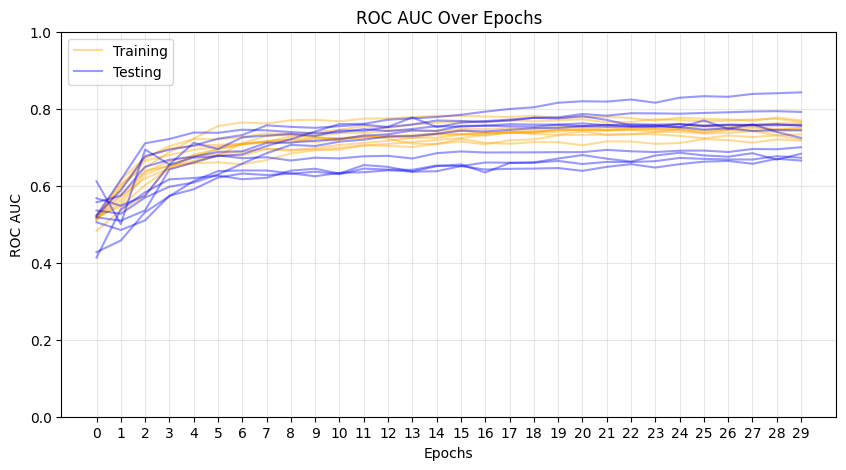

In [15]:
from visualization_stuff import show_multiple_roc_curves, show_roc_curves_over_epochs

show_multiple_roc_curves(history)

# Show ROC AUC progression over epochs (similar to accuracy plot)
train_fold_aucs, test_fold_aucs = show_roc_curves_over_epochs(history, "ROC AUC Over Epochs")

In [16]:
def show_classification_report(history):
    all_labels = []
    all_predictions = []
    for fold_data in history["test"][-1]:
        _, _, probabilities, true_labels = fold_data
        all_labels.extend(true_labels)
        all_predictions.extend([int(prob > .5) for prob in probabilities])
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_predictions))

show_classification_report(history)

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     54109
           1       0.64      0.29      0.40     21147

    accuracy                           0.76     75256
   macro avg       0.71      0.61      0.62     75256
weighted avg       0.74      0.76      0.72     75256



https://github.com/pytorch/examples/tree/main/word_language_model